# Gradient Boosting

Nun Einbeziehen der Quantile statt nur Median und Max.

- Gradient Boosting

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, metrics, manifold, preprocessing, ensemble
import joblib

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Umwandeln in statistische Features

In [7]:
stat_feat = prepare.StatFeatures2()
stat_feat.fit() # dummy

StatFeatures2()

In [8]:
X_train = stat_feat.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)

(480, 19) (480,)


In [9]:
X_test = stat_feat.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 19)
3551.38


Skalieren Trainingsdaten (eigentlich hier nicht erforderlich, aber kann nicht schaden :-)

In [10]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

Skalieren Testdaten

In [11]:
X_test_scaled = std_scaler.transform(X_test)

Stärke der Korrelation der Features zur Zielgröße

In [12]:
# erstmal DataFrame mit Features und Zielgröße aufbauen
df_train = pd.DataFrame(X_train_scaled)
df_train.columns = ['p_mean', 'p_q25', 'p_q50', 'p_q75', 'p_max', 'p_std',
                    'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std',
                    'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std',
                    'ti']
df_train['festigkeit'] = festigkeit_train

In [13]:
corr = df_train.corr()
corr['festigkeit'].abs().sort_values(ascending=False)

festigkeit    1.000000
p_max         0.861549
p_q75         0.834543
p_q50         0.812366
p_mean        0.795196
p_q25         0.765958
ti            0.676238
p_std         0.663320
f_std         0.625415
f_max         0.487235
f_q75         0.453694
d_max         0.424856
d_q75         0.387241
d_std         0.376086
d_mean        0.353475
d_q50         0.319570
f_q50         0.302010
f_mean        0.277208
d_q25         0.270749
f_q25         0.148749
Name: festigkeit, dtype: float64

Kontrollanzeige t-SNE

In [14]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

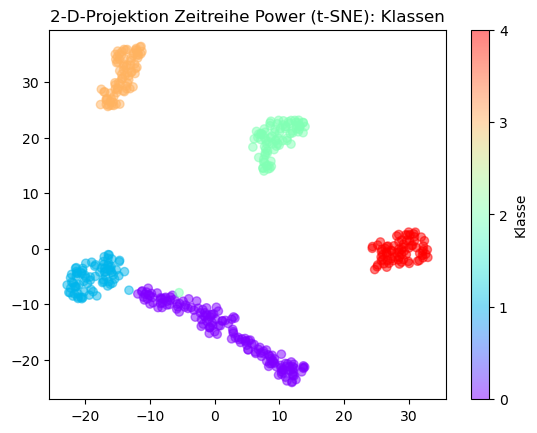

In [15]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow', alpha=0.5)
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

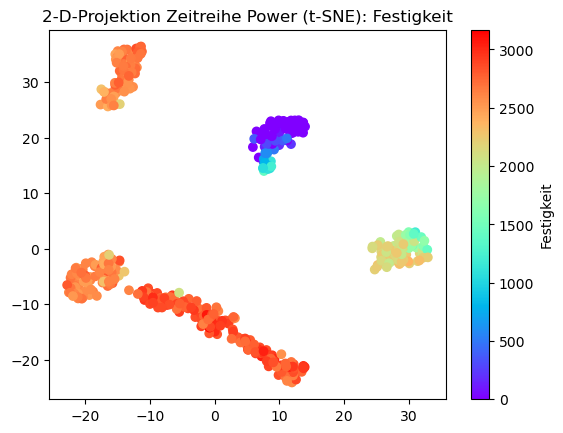

In [16]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Gradient Boosting (laut Geron, chap. 7)

In [17]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'max_depth': np.arange(2, 20),
    'n_estimators': np.arange(3, 30),
    'learning_rate': np.logspace(-2, 1),
    #'min_samples_leaf': np.arange(1, 50),
}
estim_search = model_selection.RandomizedSearchCV(
    ensemble.GradientBoostingRegressor(),
    params,
    n_iter=50,
    n_jobs=-1,
)
_ = estim_search.fit(X_train_scaled, festigkeit_train)
regr = estim_search.best_estimator_
print(estim_search.best_params_)

{'n_estimators': 18, 'max_depth': 2, 'learning_rate': 0.3906939937054617}


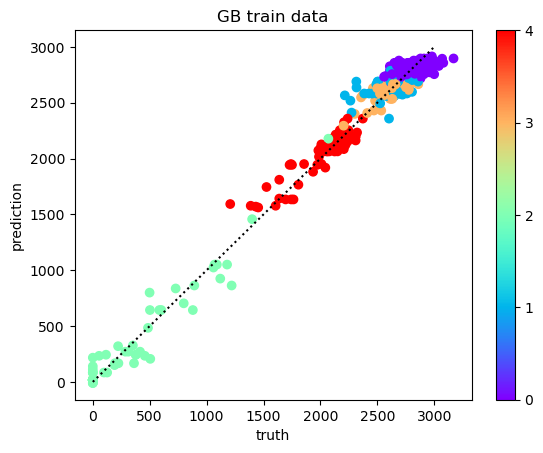

In [18]:
y_pred_train = regr.predict(X_train_scaled)
plt.plot([0, 3000], [0, 3000], 'k:')
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('GB train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))

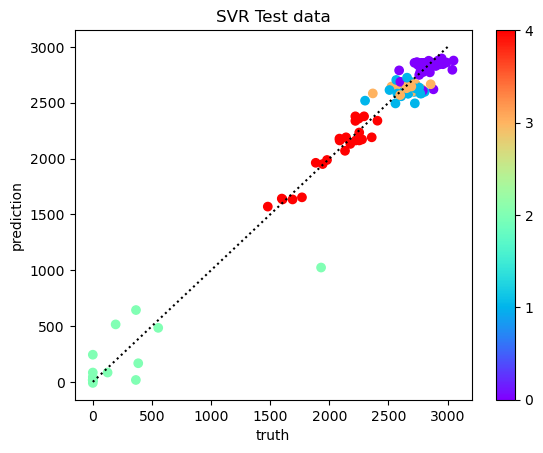

In [19]:
y_pred_test = regr.predict(X_test_scaled)
plt.plot([0, 3000], [0, 3000], 'k:')
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')

In [20]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train  10012.7, test:  18872.9
RMSE: train    100.1 test:    137.4
MAE: train     75.6, test:     88.8
